# TensoRF Color Variance

## Imports

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from tensorf_testing_suite.tensorf_models.tensoRF import TensorVMSplit

In [2]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(20211202)
np.random.seed(20211202)

## Load Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load('trained_models/tensorf_small_baseline.th', map_location=device)
kwargs = ckpt['kwargs']
kwargs.update({'device': device})
tensorf = TensorVMSplit(**kwargs)
tensorf.load(ckpt)

aabb tensor([-1.5000, -1.5000, -1.5000,  0.7913,  1.5000,  0.1299], device='cuda:0')
grid size [307, 402, 218]
sampling step size:  tensor(0.0037, device='cuda:0')
sampling number:  1098
pos_pe 6 view_pe 2 fea_pe 2
MLPRender_Fea(
  (mlp): Sequential(
    (0): Linear(in_features=150, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


## Find Color Variance

In [6]:
# ray = torch.tensor([[ 1.2144,  1.4356, -1.0000, -0.5, -0.5,  1.0000]]).to(device) # x,y,z, dx,dy,dz
ray = torch.tensor([[ 0,  0, 0, -0.5, 1, -0.75]]).to(device) # x,y,z, dx,dy,dz

In [7]:
with torch.no_grad():
    tensorf.eval()
    output = tensorf.forward(ray)

rgb_map, depth, rgb, sigma, xyz_sampled = output

rgb = rgb[0].cpu().numpy()
sigma = sigma[0].cpu().numpy()
xyz_sampled = xyz_sampled[0].cpu().numpy()


## Graphical Data Views

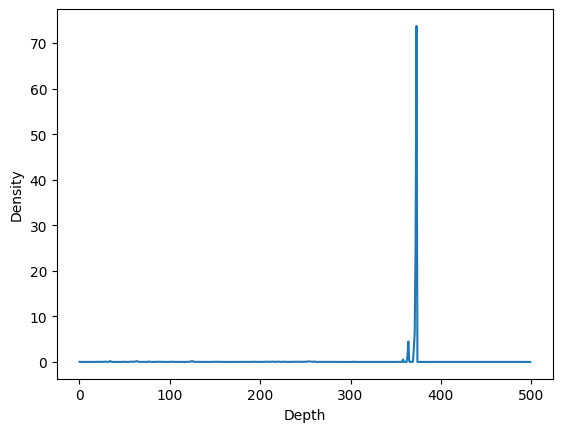

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

ax.plot(sigma[:500])

plt.show()

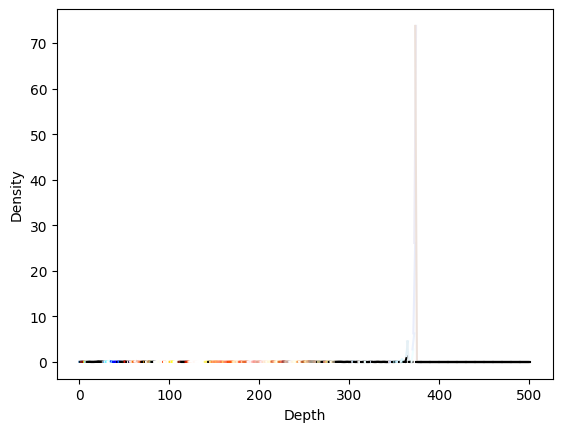

In [9]:
fig_col = plt.figure()
ax = fig_col.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

# ax.set_ylim(0, 1)
for i in range(len(sigma[:500])):
    ax.plot([i,i+2],sigma[i:i+2],color=(tuple(rgb[i])))

plt.show()

In [10]:
for i, val in enumerate(sigma):
    if val > 0.006:
        print(i)

0
1
2
20
21
22
23
24
25
28
29
30
31
32
33
34
35
36
37
43
44
45
50
51
55
56
57
58
59
60
61
62
63
64
65
66
70
71
75
76
77
78
84
85
86
87
88
89
90
91
92
100
101
102
103
104
105
106
107
108
109
110
111
119
120
121
122
123
124
125
126
127
128
129
130
131
132
135
136
137
138
146
147
148
149
150
151
152
153
154
155
156
157
158
172
173
175
176
177
178
179
180
181
184
185
186
187
188
191
192
193
194
195
197
198
199
200
201
202
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
266
267
272
273
274
275
280
281
304
311
312
317
344
345
353
354
358
359
363
364
365
370
371
372
373


In [11]:
variance_depth = 25
xyz = xyz_sampled[variance_depth]
xyz = torch.tensor(xyz).to(device).view(1,3)

sampled_ray = ray[0].cpu().numpy()
testing_views = []
size = 90
for i in range(size**2):
    testing_views.append([(((i%size)-45)/360)+sampled_ray[3], ((int(i/size)-45)/360)+sampled_ray[4], sampled_ray[5]])

testing_views = torch.tensor(testing_views, dtype=torch.float32).to(device)

variance_map = []
with torch.no_grad():
    tensorf.eval()
    for view in testing_views:
        testing_view = torch.tensor(view).to(device).view(1,3)
        variance_map.append(tensorf.get_variance(xyz, testing_view)[0].cpu().numpy())
    variance_map = np.array(variance_map)

/tmp/ipykernel_60012/1054049633.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_view = torch.tensor(view).to(device).view(1,3)


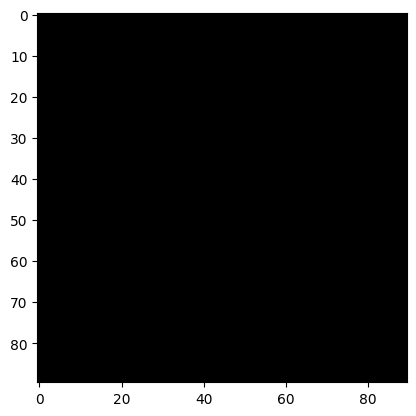

In [13]:
variance_map = variance_map.reshape(size,size,3)
imgplot = plt.imshow(variance_map)

In [15]:
from IPython.display import display, HTML

rays0 = np.load('sbrays.npy')
df = pd.DataFrame(rays0)
display(df)
print(rays0[0][0] - rays0[1][0])
print(rays0[1][0] - rays0[2][0])

,0,1,2,3,4,5
0,0.008750,-0.008750,0.0,0.060434,-0.964156,-0.258360
1,-0.008750,-0.017500,0.0,-0.050247,-0.936729,-0.346432
2,0.017500,0.013125,0.0,0.244152,0.211362,-0.946423
3,-0.013125,0.017500,0.0,-0.387214,-0.577960,-0.718350
4,0.008750,0.000000,0.0,-0.135306,0.941825,-0.307665
...,...,...,...,...,...,...
4091,0.013125,0.017500,0.0,-0.010831,-0.980224,-0.197593
4092,0.004375,-0.008750,0.0,0.151690,0.608866,-0.778635
4093,0.008750,0.008750,0.0,0.086188,-0.915157,-0.393775
4094,0.004375,0.000000,0.0,0.118843,0.894704,-0.430559


0.0175
-0.026250001


In [14]:
testing_rays = []
size = 512 #1024
for i in range(size):
    for j in range(size):
        testing_rays.append([1.5-j/size*2, 1.5-i/size*2, -1.7500, -0.5, -0.5,  2.0000])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

100%|██████████| 64/64 [00:01<00:00, 32.94it/s]


In [23]:
aabb = [-0.6732, -1.1929, -0.4843,  0.6732,  1.1929,  1.0512]

testing_rays = []
size = 512 #1024
for i in range(size):
    for j in range(size):
        testing_rays.append([2-j/size, -1, 3-i/size*2, -0.5, 0.5, -0.5])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

100%|██████████| 64/64 [00:00<00:00, 78.72it/s] 


In [4]:
ray = torch.tensor([[ 0,  0, 0, -0.5, 1, -0.75]]).to(device) # x,y,z, dx,dy,dz

testing_rays = []
size = 128 #1024
for i in range(size):
    for j in range(size):
        # testing_rays.append([0.0175, 0, 0, -0.125, 1-i/size*2, 1-j/size*2])
        testing_rays.append([0.0175, 0, 0, -0.125, -i/size*2, -j/size*2])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


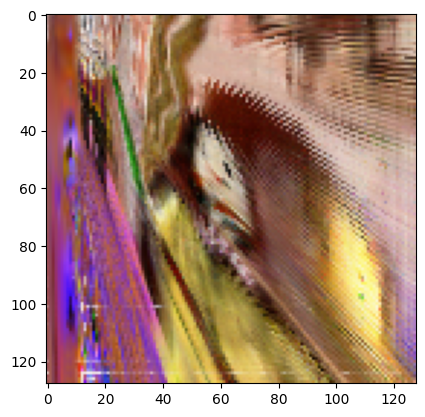

In [6]:
rgb_map = np.array(output)
rgb_map = rgb_map.reshape(size,size,3)
imgplot = plt.imshow(rgb_map)

In [21]:
img = Image.fromarray((rgb_map*255).astype(np.uint8))
img.save("trex.png")